In [8]:
# import stuff
import sys,os
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append( os.environ["PYTHONSCRIPT_DIR"] )

import matplotlib as mpl
import PlotSettings as pS
pS.loadPlotSettings(mpl)

rcParamsOrig  = mpl.rcParams.copy();

lineSettings = pS.generalSettings.defaultLineSettings 
defaultMarkerSize = pS.generalSettings.defaultMarkerSize

from Tools.Parsers.Utilities import parseNDArray

print(" HPCJobConfigurator: ", os.environ["JOBGENERATOR_DIR"])
sys.path.append( os.environ["JOBGENERATOR_DIR"])
import HPCJobConfigurator.jobGenerators.commonFunctions  as cf 


import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from skimage.io import imread
from skimage.filters import *
from skimage.morphology import *
from skimage import data
from skimage import img_as_float
from skimage.morphology import disk


#GUi shit
%matplotlib tk
#mpl.get_configdir()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting matplotlib settings from file: /home/zfmgpu/Desktop/Repository/SimulationFramework/SourceCode/Projects/SimulationFramework/Simulations/PythonScripts/PlotSettings/matplotlibrc
 HPCJobConfigurator:  /home/zfmgpu/Desktop/Repository/HPCJobConfigurator


GridFile
===

In [9]:
# GridFile
import re
import h5py
import glob2

class GridFile:
    
    class OOBB:
        pass;
    class Bounds:
        pass;
    
    def __init__(self,filePath):
        self.filePath = filePath
        self.h5file=h5py.File( self.filePath , 'r')
        
        self.dim = self.h5file["GridSettings/dimensions"][...].flatten().astype(int)
        
        self.oobb = GridFile.OOBB();
        self.oobb.minPoint = self.h5file["GridSettings/OOBB/minPoint"][...].flatten()
        self.oobb.maxPoint = self.h5file["GridSettings/OOBB/maxPoint"][...].flatten()
        self.oobb.R_KI = self.h5file["GridSettings/OOBB/R_KI"][...]
        
        self.bounds = GridFile.Bounds()
        self.bounds.min = self.h5file["GridSettings/Bounds/minPoint"][...].flatten()
        self.bounds.max = self.h5file["GridSettings/Bounds/maxPoint"][...].flatten()
        self.bounds.dx  = (self.bounds.max-self.bounds.min) / self.dim
        
        
        self.numIndices = self.dim.size
        self.numIndicesSqueezed = np.where(self.dim>1)[0].size
        
        self.states = []
        nFiles = len(self.h5file["Files"]);
        for name,s in self.h5file["States"].items():
             self.states.append( {"time": np.asscalar(s.attrs["time"]), 
                                  "stateIdx": np.asscalar(s.attrs["stateIdx"]),
                                  "globalStateIdx": 
                                          s.attrs["globalStateIdx"] if "globalStateIdx" in s.attrs  
                                          else (np.asscalar(s.attrs["stateIdx"]) if nFiles == 1 else -1 ),
                                  "h5Group":s} )
        
        self.states.sort(key=lambda x: x["time"])
        
    def __str__(self):
        return "<GridFile @ %s>" %self.filePath 
    
    def getAxisPoints(self,indexSlices,where="beg"):
        '''Builds the axis points on the grid, either at the beginning of each cell or '''
        indexSlices = self.buildGridSliceMinMax(indexSlices)
        print("AxisPoints for slice: ", indexSlices)
        axes = []
        for axis, sl in enumerate(indexSlices):
            p = np.array(range(0,self.dim[axis])[sl])
            if where=='beg':
                 axes.append(self.bounds.min[axis] + p*self.bounds.dx[axis])
            elif where=='mid':
                 axes.append(self.bounds.min[axis] + (p + 0.5)*self.bounds.dx[axis])
            else:
                 axes.append(self.bounds.min[axis] +(p + 1)*self.bounds.dx[axis])
        return axes
    
    def getPlotBounds(self,whichIndices):
        return np.vstack([self.bounds.min,self.bounds.max])[:,whichIndices].T.reshape((2*len(whichIndices),))
    
    def getStates(self):
        return self.states

    def readGrid(self,stateIdx,gridName, remove1Daxes=True):
        '''stateIdx can either be an int with value x corresponding to the "/State/S%i" % x group
           or the direct state h5file group object
        '''
        
        if isinstance(stateIdx,int):
            gridData = self.h5file["States/S%i/%s" % (stateIdx,gridName)][...]
        elif isinstance(stateIdx,h5py.Group):
            gridData = stateIdx[gridName][...]
        
        if(remove1Daxes):
            return np.squeeze(gridData)
        else:
            return gridData
    
    def getIndex(self,K_loc,axis=0):
        ''' K_loc is in K frame and relative to self.bounds.min (./Bounds/minPoint)'''
        assert axis in range(0,self.numIndices)
        i = ((K_loc - self.bounds.min[axis]) / self.bounds.dx[axis]).astype(int)
        return max(0,min(i,self.dim[axis]-1))
    
    def getIndices(self,K_p):
        ''' K_p is in K frame and relative to self.bounds.min (./Bounds/minPoint)'''
        i=((K_p - self.bounds.min) / self.bounds.dx).astype(int)
        return np.maximum(0,np.minimum(i,self.dim[axis]-1))


    def buildGridSliceMinMax(self,minMaxSlice):
        """
            A minMaxSlice in the form [ rangeAxis0, rangeAxis1,...], 
            is transformed into [ slice() , slice(), ... ] with indices in the grid
            if the rangeAxisX is already a slice() object it is not altered!
            allowing to combine slices and minMaxRanges
        """
        
        def makeSlice(minMax,axis):
            if minMax is None:
                return slice(0,None)
            
            if not isinstance(minMax,slice):
                if( len(minMax) > 1 ):
                    return slice(self.getIndex(minMax[0],axis),
                                 self.getIndex(minMax[1],axis))
                else:
                    # we only have one min value, take only this index
                    i = self.getIndex(minMax[0],axis)
                    return slice(i,i+1)
            else:
                return minMax
        # transform all minMaxSlices into index slices
        return [ makeSlice(minMax,axis) for axis, minMax in enumerate(minMaxSlice) ]
    
    
    def loadGrids(self,stateSlice=slice(0,None), 
                  gridName = "velocity", 
                  gridSlice = None, 
                  preSliceOperator  = lambda x: x,
                  postSliceOperator = lambda x: x,
                  **kwargs):
    
        data = []
        if stateSlice is not None:
            states = self.states[stateSlice]
        else:
            states = self.states
    
        for s in states:
            
            if gridSlice is None:
                grid = postSliceOperator(preSliceOperator(self.readGrid(s["h5Group"],gridName,**kwargs)))   
            else:
                sl = self.buildGridSliceMinMax(gridSlice)
                grid = postSliceOperator(preSliceOperator(self.readGrid(s["h5Group"],gridName,**kwargs))[sl])

            data.append({"grid" : grid })
        
        return data,states
    
    
    def assembleStates(self, data=None, **kwargs):
        """ Returns tensor (x,y,....,t) , where t is the time idx, and a list of all """
        if data is None:
            data,states = self.loadGrids(**kwargs)
            
        stateLength = len(data);
        
        assert stateLength > 0, "Time dimension == 0"
        
        # make new grid with one more dimensions which is the stateIdx
        timeData = np.ndarray(data[0]["grid"].shape + (stateLength,) ,
                              dtype= data[0]["grid"].dtype)
        
        # write all data to the timeData
        for tIdx,d in enumerate(data):
            timeData[...,tIdx] = d["grid"]
        
        return timeData,states
                            
        
        
        
    
    

Settings
===

In [10]:
# Settings ===========================================================================
from scipy.ndimage.filters import gaussian_filter

def loadIniFile(file):
    # no interpolation is done!
    import configparser
    config = configparser.ConfigParser(interpolation=None)
    config.read(file)
    return config

def generateColorMap(min,max,name):
    jet = colorMap = plt.get_cmap(name) 
    cNorm  = colors.Normalize(vmin=min, vmax=max)
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=colorMap)
    return scalarMap;


def getAllFiles(globEx,regex, key=lambda m: int(m.group(1))):
    files = glob2.glob(globEx)
    l={}
    for f in files:
        try:
            l[ key(re.match(regex,f)) ] = f
        except:
            pass
    if not l:
        raise ValueError("No files found for %s " % globEx)  
    return l

def getAllGridFiles(globExpr):
    # Glob all files
    filePaths = sorted(glob2.glob(globExpr))

    filesPerStudyNr = {}
    for f in filePaths:
        m=re.match(".*P-(\d*).*",f);
        if(m):
            nr = int(m.group(1))
            if nr not in filesPerStudyNr:
                filesPerStudyNr[nr] = {}
            filesPerStudyNr[nr][os.path.basename(f)] = f
            
    return filesPerStudyNr

# All sort of plot settings ==========================================================
thisRootFolder = "../"
simulationJobsFolder =  os.path.join(thisRootFolder,"../SimulationJobs")
studyJobIniFile = os.path.join( simulationJobsFolder, "StudyConfig.ini")
studyConfig = loadIniFile(studyJobIniFile)["ParameterStudy"]

""" Add an anchored text to the axis """
def addText(ax, t, loc=2, textp = dict(size=12), pad = 0.1, borderpad = 0.5 ,
            frameon =True, 
            fc="white", ec="black" ,lw=1):

     return ax.annotate(t, (1,0), (0, -20), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top', ha='right', 
                 **textp)


fileGlobbingExpression = "./gridVelocities/rough/GridVelocity-P-*/*.h5"
filesPerStudyNr = getAllGridFiles(fileGlobbingExpression)
print("Files: ", filesPerStudyNr)
studyNrs = sorted(list(filesPerStudyNr.keys()))

corrExperimentNr = 5;
expSettingsFile = os.path.join(thisRootFolder,"data/ExperimentSettings.json")
# Load ExperimentSettings json
expSettings = cf.jsonLoad(expSettingsFile)
expSet = expSettings["experiments"][str(corrExperimentNr)]
expFrameRate = expSettings["framerate"]
expStartIdx  = expSet["startIdx"]
expDeltaT    = 1.0/expFrameRate

# Load StudyEntryData
studyEntryDataFile  = os.path.join(thisRootFolder,"data/StudyEntryData.json")
studyEntryData = cf.jsonLoad(studyEntryDataFile)

#Scene file (if needed)
sceneFile = "./../data/SceneFile.xml"

# CIV stuff ============================================
expBackgroundFile = "./experimentBackground.jpg"
expBackground = np.flipud(img_as_float(imread(expBackgroundFile, as_grey = True))).transpose()
expOrigImageRegex = r".*?-(\d*).*"
expOrigImageFiles= getAllFiles("./experiment/*", expOrigImageRegex)
    
    
computeNewMask = True
otsuThMult = 0.7

civImageName = "data"
civMaskName = "finalMask"
civVelXName = "vx"
civVelYName = "vy"
civImageDataPostLoadOperator = lambda x : x.transpose() # the h5 file for the civ (acciv) uses (y,x, origin at lower-left corner) , thats why we transpose the image!
# tree mask
treeMaskFile = "./treemask.jpg"

# Get all CIV image files and sort according to frame number
civImageRegex = r".*?CIVRough.*?f-(\d*).*"
civImageFiles= getAllFiles("./civImageFiles/*",civImageRegex)

# Get all CIV grid files and sort according to frame number
civPassNr = 2
civGridRegex = r".*?CIVRough.*?p-%i-f-(\d*).*" % civPassNr
civGridFiles= getAllFiles("./civGridFiles/*",civGridRegex)
def getCIVFrameIdx(simRelTimeFromEntry, expDeltaT, expStartIdx):
    return int(round( simRelTimeFromEntry / expDeltaT )) + expStartIdx

# load treeMask (flip = origin at lower left corner, and make (x,y) indices)
treeMask = np.flipud(imread(treeMaskFile,as_grey = True)).transpose()

# =======================================================
    
    
    
# Slice specification =============================
gridFileName = "GridFileVelocityField.h5"
gridName   = "velocity"
maskName   = "mask"
stateSlice = slice(0,None)
gridSlice  = [ (-0.05,),(-0.15,0.15)]   
sliceSpec  = dict(name="vertical",stateSlice=stateSlice,gridSlice=gridSlice)

# make velocity magnitude
preSliceOperator  = lambda x:  x
postSliceOperator = lambda grid: gaussian_filter(np.sqrt(grid[...,0]**2 + grid[...,1]**2),sigma=7)

# velocity norm range ( [xmin,ymin],[xmax,ymax])
velocityRange = np.array([[0,-0.4],[-2.0,0.4]])
velocityMaxNorm =  np.around(np.linalg.norm(velocityRange[1] - velocityRange[0]),decimals=1)

# ================================================

# Some mask convertions ============================

def removeSmallObjects(g):
    return g #remove_small_objects(g,min_size=8000,connectivity=1)

def makeSimMask(g):
    if(len(g.shape)==3):
        # last index is time move over that one
        for i in range(g.shape[2]):
            g[:,:,i] = np.logical_not( 
                removeSmallObjects((treeMask*g[:,:,i]).astype(bool)) 
                 )
        return g
    else:
        return np.logical_not(removeSmallObjects((treeMask*g).astype(bool))) 

def makeCivMask(image,background):
    subtracted = np.abs(image - background)
    th = threshold_otsu(subtracted)
    # threshol with otsu
    binary = subtracted > otsuThMult*th
    return binary
# ==================================================


# figure stuff
oneSidePlot = True
labelLength = "B-14\hspace{0.2em}"

if oneSidePlot:
    figureSize= (pS.cm2inch(15.8),pS.cm2inch(10))
    legendProps = dict(prop=dict(size=10),borderpad=0.35,labelspacing=0.2,handletextpad=0.3,markerscale=1,borderaxespad=1)
else: 
    labelLength = 5.5 # für factor 1.0 -> 5.5
    figureSize= (pS.cm2inch(8),pS.cm2inch(6))
    legendProps = dict(prop=dict(size=6),borderpad=0.35,labelspacing=0.1,handletextpad=0.3,markerscale=1)

# label formatter
class LabelFormatter:
    def __init__(self,parameterStudyConfig):
        self.muList = cf.jsonParse(parameterStudyConfig["muList"])
    def __call__(self,studyNr, param=True,labelLength = labelLength):
        if studyNr == 15: 
            studyNr = 14
            add=r"$\overbar{\textnormal{B}}$"
        else:
            add="B"
        if param:
            return r"\parbox{\widthof{%s}}{%s-%i}, $\mu\!=\!%.1f$" % (labelLength,add,studyNr,self.muList[studyNr])
        else:
            return r"\parbox{\widthof{%s}}{%s-%i}" % (labelLength,add,studyNr)
        
labelFormatter = LabelFormatter(studyConfig)

# color map
studyCMapName = "spectral"
colorMap = generateColorMap(min(studyNrs),max(studyNrs),studyCMapName).to_rgba

# ====================================================================================

Files:  {3: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-3/GridFileVelocityField.h5'}, 4: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-4/GridFileVelocityField.h5'}, 5: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-5/GridFileVelocityField.h5'}, 6: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-6/GridFileVelocityField.h5'}, 7: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-7/GridFileVelocityField.h5'}, 8: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-8/GridFileVelocityField.h5'}, 9: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-9/GridFileVelocityField.h5'}, 10: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-10/GridFileVelocityField.h5'}, 11: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-11/GridFileVelocityField.h5'}, 12: {'GridFileVelocityField.h5': './gridVelocities/rough/GridVelocity-P-12/Gri

In [ ]:
studNr = 3
g=GridFile(filesPerStudyNr[studNr]["GridFileVelocityField.h5"])

gridVel = g.readGrid(stateIdx = 5, gridName="velocity")
gridVelMag = np.sqrt(gridVel[...,0]**2 + gridVel[...,1]**2)
print("Shape of Grid: ", gridVel.shape)
print("Shape of Grid mag.: ", gridVelMag.shape)

sl = g.buildGridSliceMinMax([(-0.7,-0.29),slice(100,200)])
print("Slice",sl)

stateSlice, states = g.assembleStates(stateSlice=slice(0,None), gridSlice=[(-0.7,-0.29),(0.1,)],gridName="velocity")
print("Slice:", stateSlice.shape)


Test Plot 2D
===

In [ ]:
# plot test
g = GridFile(filesPerStudyNr[3]["GridFileVelocityField.h5"])

bounds = g.getPlotBounds((0,1))
print("Bounds:",bounds)

gridVel = g.readGrid(3,"velocity")
gridVelMag = np.sqrt(gridVel[:,:,0]**2 + gridVel[:,:,1]**2)

from   mpl_toolkits.axes_grid1 import make_axes_locatable

plt.close("all")
# images for imshow and skimage are (M,N,{1,2,3}) where M are the vertical pixels (y-Axis) and N the horizontal (x-Axis)
# out grid is (M,N,{1,2,3}) where M is the x axis and N the y-Axis, so we transpose the grid 

fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal', axisbg=[1,1,1])
im = ax.imshow(gridVelMag.T, origin='lower', extent=bounds, cmap=plt.get_cmap('jet') , interpolation='none')
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="2%", pad=0.2)
fig.colorbar(im, cax = cax1)
im.set_clim(0,velocityMaxNorm)
ax.grid()
# ax.set_aspect('equal')
# ax.set_title(r'$||\mathbf{v}||$')

Build Slices over all GridFiles and Studies
===

In [11]:
# build slices over all files
def buildSlicesPerStudy(filesPerStudyNr, 
                gridFileName,
                gridName,
                sliceSpecs,
                postAssembleOperator = lambda x : x,
                **kwargs
               ):
    
    ''' spliceSpecs is a dictionary with "gridSlice" : gridSlice and a "stateSlice": stateSlice 
        which are handed over to GridFile.assembleStates which slices the grid with name gridName
        by the gridSlice and assembles all states sliced by stateSlice
    '''
    
    data = {}
    
    for studyNr, files in filesPerStudyNr.items():
        
        # for all slice specs 
        for slSpec in sliceSpecs:
            
            sliceName = slSpec["name"]
            gridSl = slSpec["gridSlice"]
            stateSl = slSpec["stateSlice"]
            
            g = GridFile(files[gridFileName])

            stateSlice, states = g.assembleStates(stateSlice=stateSl, 
                                                  gridSlice=gridSl,
                                                  gridName=gridName,**kwargs)
            stateSlice = postAssembleOperator(stateSlice)
            
            timeList = np.array([ s["time"] for s in states ])
            stateIndices = np.array([ s["stateIdx"] for s in states])

            data[studyNr] = {"gridFile" : g,
                             "slice":stateSlice, 
                             "time": timeList, 
                             "stateIndices" : stateIndices,
                             "sliceSpecs" : slSpec
                             }
    return data
        


In [ ]:
# Make plots (slices from above)

# Get 1D slices over all states
studyData = buildSlicesPerStudy(filesPerStudyNr,
                    gridFileName=gridFileName,
                    gridName=gridName,
                    sliceSpecs=[sliceSpec],
                    postAssembleOperator = lambda g: np.squeeze(g),
                    postSliceOperator = postSliceOperator,
                    preSliceOperator  = preSliceOperator
                   )


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.colors import colorConverter
cc = lambda arg: colorConverter.to_rgba(arg, alpha=1.0)

fig = plt.figure(figsize=figureSize)
ax = fig.add_subplot(111,projection='3d')
#ax.ticklabel_format(style='sci',scilimits=(0,0),axis='y')

studyRange = range(3,15,1)

for studyNr, data in studyData.items():
        
    if studyNr in studyRange:
        gridFile = data["gridFile"]

        #       sl = [slice(0,None,4),slice(0,None)]

        #       print("Plot slice: " , data["stateSlice"].shape)

        #       # get axes points
        axesPoints = gridFile.getAxisPoints(sliceSpec["gridSlice"])

        #plot wireframe
#         axisPointsM ,timePointsM = np.meshgrid(axesPoints[1],data["time"],indexing='ij')
#         ax.plot_wireframe(axisPointsM,timePointsM,data["stateSlice"], color=colorMap(studyNr))

        # plot 3d lines
        lines = np.ma.asarray(np.zeros(( len(data["time"]) , data["slice"].shape[0], 2 )))
        zValues = data["slice"].T
        lines[:,:,0] = axesPoints[1] # x values
        lines[:,:,1] = np.ma.masked_where((zValues<0.00), zValues) # zvalues, masking all values will result in plot failure
        lc = LineCollection( lines , colors=colorMap(studyNr) , linestyles = 'solid', linewidths=1)
        ax.set_xlim(axesPoints[1].min(),axesPoints[1].max())
        ax.set_ylim(data["time"].min(),data["time"].max())
        ax.set_zlim(zValues.min(),zValues.max())
        ax.add_collection3d(lc, zs=data["time"],zdir='y')

        ax.set_xlabel("y [m]")         
        ax.set_ylabel("t [s]")

In [12]:
# error metric
def maskOvelapRatio(data1,data2):
    # overlapRatio: sum( A intersect B) / sum(A union B)
    # how many pixels overlap of the total united region
    return np.sum(data1 & data2)/np.sum(data1 | data2)

# Grid Matching function
def rootMeanSqErrorMaskedData(data1,data2):
    rMeanSqErr = np.sqrt(((data1-data2)**2).mean())
    return rMeanSqErr,maskOvelapRatio(data1.mask,data2.mask)



Match Simulation and CIV Analysis
===

In [14]:
# Prepare data for best matching maskes of the sim. studies compared to the
# mask of the images of the CIV results

# load all maskes of the simulation grid files
sliceSpec  = dict(name="mask",stateSlice=None, gridSlice=None)

# Load Masks and Velocities from Simulation ===================
studyDataMasks = buildSlicesPerStudy(filesPerStudyNr,
                    gridFileName=gridFileName,
                    gridName=maskName,
                    sliceSpecs=[sliceSpec],
                    postAssembleOperator = lambda g: np.squeeze(g),
                    postSliceOperator  = lambda x: x,
                    preSliceOperator   = lambda x: x)

sliceSpec["name"] = "velocity"
studyDataVelMag = buildSlicesPerStudy(filesPerStudyNr,
                    gridFileName=gridFileName,
                    gridName=gridName,
                    sliceSpecs=[sliceSpec],
                    postAssembleOperator = lambda g: np.squeeze(g),
                    postSliceOperator  = lambda g: np.sqrt(g[:,:,0]**2 + g[:,:,1]**2), # make magnitude
                    preSliceOperator   = lambda x: x)

# set all masks
for studyNr,study in studyDataVelMag.items(): 
    study["slice"] =  np.ma.masked_array(study["slice"] , mask=makeSimMask( studyDataMasks[studyNr]["slice"] ) )
#===============================================================

# match masks with civ masks
loadedCIVMasks = {}
loadedCIVData  = {}

for studyNr,study in studyDataVelMag.items():
    
    entryTime = studyEntryData["studies"][str(studyNr)]["entryTime"]
    
    civMask   = np.zeros(expSettings["resolution"]+[len(study["time"])] ,dtype=np.uint8)
    civVelMag = np.zeros(expSettings["resolution"]+[len(study["time"])] ,dtype=float)
    print("Load CIV mask/data (shape: %s) for studyNr: %i" % (str(civMask.shape),studyNr))
    
    # for each time match the civ image and load mask and velocity
    civIndices = []
    for i,t in enumerate(study["time"]):
        
        print("match time: ", t)
        civIdx = getCIVFrameIdx(t-entryTime,expDeltaT,expStartIdx)
        civIndices.append(civIdx)
        print("civ idx: ", civIdx)
        
        # load the image file and get mask if not yet loaded
        if civIdx not in loadedCIVMasks:
            print("Load CIV %s for simTime: %f at frameIdx: %i" % (maskName,t,civIdx))
            f = h5py.File(civImageFiles[civIdx])
            
            if computeNewMask:
                # image is (y,x, origin at lower left corner)
                image = f[civImageName][...].transpose() # make it (x,y)
                mask = treeMask * makeCivMask(image,expBackground)
            else:
                mask = civImageDataPostLoadOperator(f[civMaskName][...].astype(np.uint8))
                
            loadedCIVMasks[civIdx] = mask
            
        # load the data file (velocities) if not yet loaded
        if civIdx not in loadedCIVData:
            print("Load CIV velocity for simTime: %f at frameIdx: %i" % (t,civIdx))
            f = h5py.File(civGridFiles[civIdx])
            velMag = np.sqrt(f[civVelXName][...]**2 + f[civVelYName][...]**2).T

            loadedCIVData[civIdx] = velMag
        
        civVelMag[:,:,i] = loadedCIVData[civIdx]    
        civMask[:,:,i]   = loadedCIVMasks[civIdx]
    
    # set all stuff for this study
    study["civVelMag"] = np.ma.masked_array(civVelMag, mask= np.logical_not(civMask) )
    study["civIndices"] = civIndices
    study["entryTime"] = entryTime
    
for studyNr,study in studyDataVelMag.items():    
    # Compute mask/velocity match quality from simulation to civMask
    
    print("Compute overlapRatio/meanError of CIV / SIM for study: ", studyNr)
    
    overlapRatio =  study["overlapRatioSimCiv"] = np.ndarray((len(study["time"])),dtype=float)
    rMeanError    =  study["velMagMeanError"]   = np.ndarray((len(study["time"])),dtype=float)
    
    for i,t in enumerate(study["time"]):
        civVelMag = study["civVelMag"][:,:,i]
        simVelMag = study["slice"][:,:,i]
        # compute ratio
        rMeanError[i], overlapRatio[i]  = rootMeanSqErrorMaskedData(simVelMag,civVelMag)

Load CIV mask/data (shape: (800, 600, 20)) for studyNr: 3
match time:  0.242
civ idx:  340
Load CIV mask for simTime: 0.242000 at frameIdx: 340
Load CIV velocity for simTime: 0.242000 at frameIdx: 340
match time:  0.284
civ idx:  382
Load CIV mask for simTime: 0.284000 at frameIdx: 382
Load CIV velocity for simTime: 0.284000 at frameIdx: 382
match time:  0.326
civ idx:  424
Load CIV mask for simTime: 0.326000 at frameIdx: 424
Load CIV velocity for simTime: 0.326000 at frameIdx: 424
match time:  0.368
civ idx:  466
Load CIV mask for simTime: 0.368000 at frameIdx: 466
Load CIV velocity for simTime: 0.368000 at frameIdx: 466
match time:  0.41
civ idx:  508
Load CIV mask for simTime: 0.410000 at frameIdx: 508
Load CIV velocity for simTime: 0.410000 at frameIdx: 508
match time:  0.452
civ idx:  550
Load CIV mask for simTime: 0.452000 at frameIdx: 550
Load CIV velocity for simTime: 0.452000 at frameIdx: 550
match time:  0.494
civ idx:  592
Load CIV mask for simTime: 0.494000 at frameIdx: 592

In [26]:
# make plot of matching quality over time
plt.close("all")
fig = plt.figure(figsize=figureSize)
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
ax.set_ylabel(r"overlap ratio $\frac{\sum (\mmB_{\mathrm{S}} \land \mmB_{\mathrm{E}})}{\sum (\mmB_{\mathrm{S}} \lor \mmB_{\mathrm{E}})}$")
ax.set_xlabel("relative time after entry [$\mathrm{s}$]")

for studyNr in reversed(studyNrs):
    study = studyDataVelMag[studyNr]
    time = study["time"] - study["time"][0] 
    ax.plot(time,study["overlapRatioSimCiv"],color=colorMap(studyNr),label=labelFormatter(studyNr,True),
            marker='o',ms=defaultMarkerSize,lw=lineSettings["thin"])
    
ax.set_ylim([None,1])
ax.legend(loc=3, **legendProps) # bbox_to_anchor=(0.02,0.02)
ax.grid(which='minor', alpha=0.15, linestyle=':')
ax.margins(0.04, 0.04)
fig.tight_layout(pad=0.1)
pS.defaultFormatAxes(ax)
plt.subplots_adjust(left=0.12)
fig.savefig("overlapRatio.pdf")


fig = plt.figure(figsize=figureSize)
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
ax.set_xlabel("relative time after entry [$\mathrm{s}$]")
ax.set_ylabel(r"$\mathrm{RMSE}(\mathbf{V}_\mathrm{M,S},\mathbf{V}_\mathrm{M,E})$ [$\mathrm{m/s}$]")

for studyNr in (studyNrs):
    study = studyDataVelMag[studyNr]
    time = study["time"] - study["time"][0] 
    ax.plot(time[1:-1], study["velMagMeanError"][1:-1],color=colorMap(studyNr),label=labelFormatter(studyNr,False),
            marker='o',ms=defaultMarkerSize, lw=lineSettings["thin"])
    
ax.legend(loc=3,ncol=3,columnspacing=0.5,**legendProps)
ax.grid(which='minor', alpha=0.15, linestyle=':')
fig.tight_layout(pad=0.1)
pS.defaultFormatAxes(ax)
fig.savefig("rootMeanSquareError.pdf")
# plt.subplots_adjust(left=0.22, bottom=0.2, right=0.99, top=0.95, wspace=0, hspace=0)


In [13]:
from mpl_toolkits.axes_grid import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
# define function for plotting a 2d grid
def plotGridData2d(ax,
                   data,
                   bounds, 
                   timeAnnotation=False,
                   climRange=[0,velocityMaxNorm],
                   cbarFormat = ticker.FuncFormatter(lambda x,pos: r"$%0.1f$"%x),
                   xLabel = r'$x$ [m]', yLabel = r'$y$ [m]',
                   cbarTitle = r'$[\mathrm{m/s}]$',
                   noLabels = False,
                  ):

    ax.set_axisbelow(True)
    if not noLabels:
        ax.set_xlabel(xLabel)
        ax.set_ylabel(yLabel)
    #image
    im = ax.imshow(data, origin='lower', extent=bounds, cmap=plt.get_cmap('jet') , 
                   interpolation='nearest',zorder=1.2, clim=climRange)
    
    # colorbar
    if cbarFormat:
        divider = make_axes_locatable(ax)
        cax1 = divider.append_axes("right", size="3%", pad=0.2)
        cax1.tick_params(length=3)
        c=fig.colorbar(im, cax = cax1, format=cbarFormat)
        for l  in cax1.yaxis.get_ticklabels()[1::2]:
              l.set_visible(False)
        cax1.set_title(cbarTitle,fontsize=10)
    # grid
    ax.grid(linestyle="-",linewidth=lineSettings["extra-thin"], color=[0.5]*3)
    
    # remove every second label
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    # ticks
    ax.tick_params(top='off',right='off',bottom='off',left='off')
    
    # mark time
    timeText = None
    if timeAnnotation:
        timeText =  ax.annotate(timeAnnotation, (0,1.0), (0, 10), xycoords='axes fraction', 
                    textcoords='offset points', va='top', ha='left',size=pS.defaultFontSize-2)
    
    fig.tight_layout(pad=0.1)    
    pS.defaultFormatAxes(ax)
    
    if cbarFormat:
        pS.defaultFormatColorbar(c)

    return im,timeText

[-0.80922446  0.01756937 -0.3214161   0.29867927]
2.2


/opt/python3.4Env/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


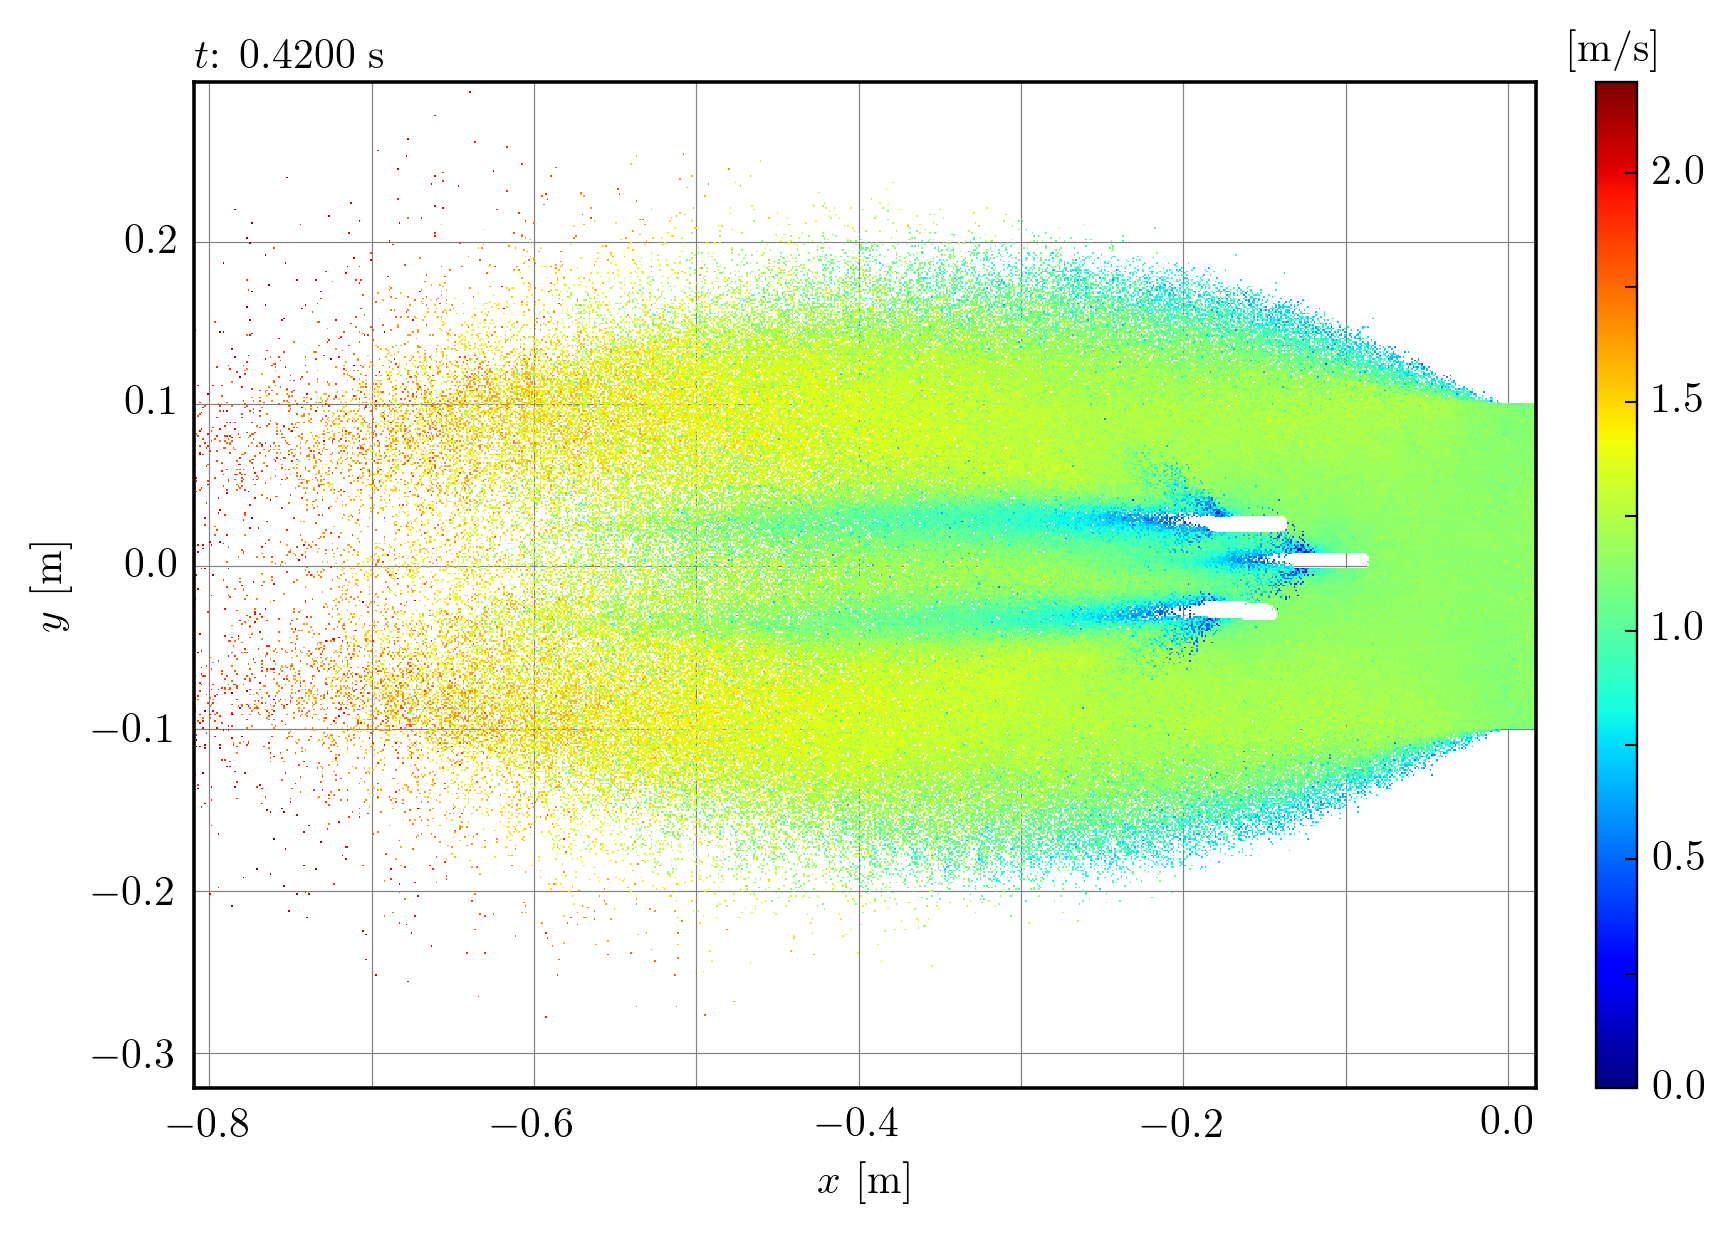

/opt/python3.4Env/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


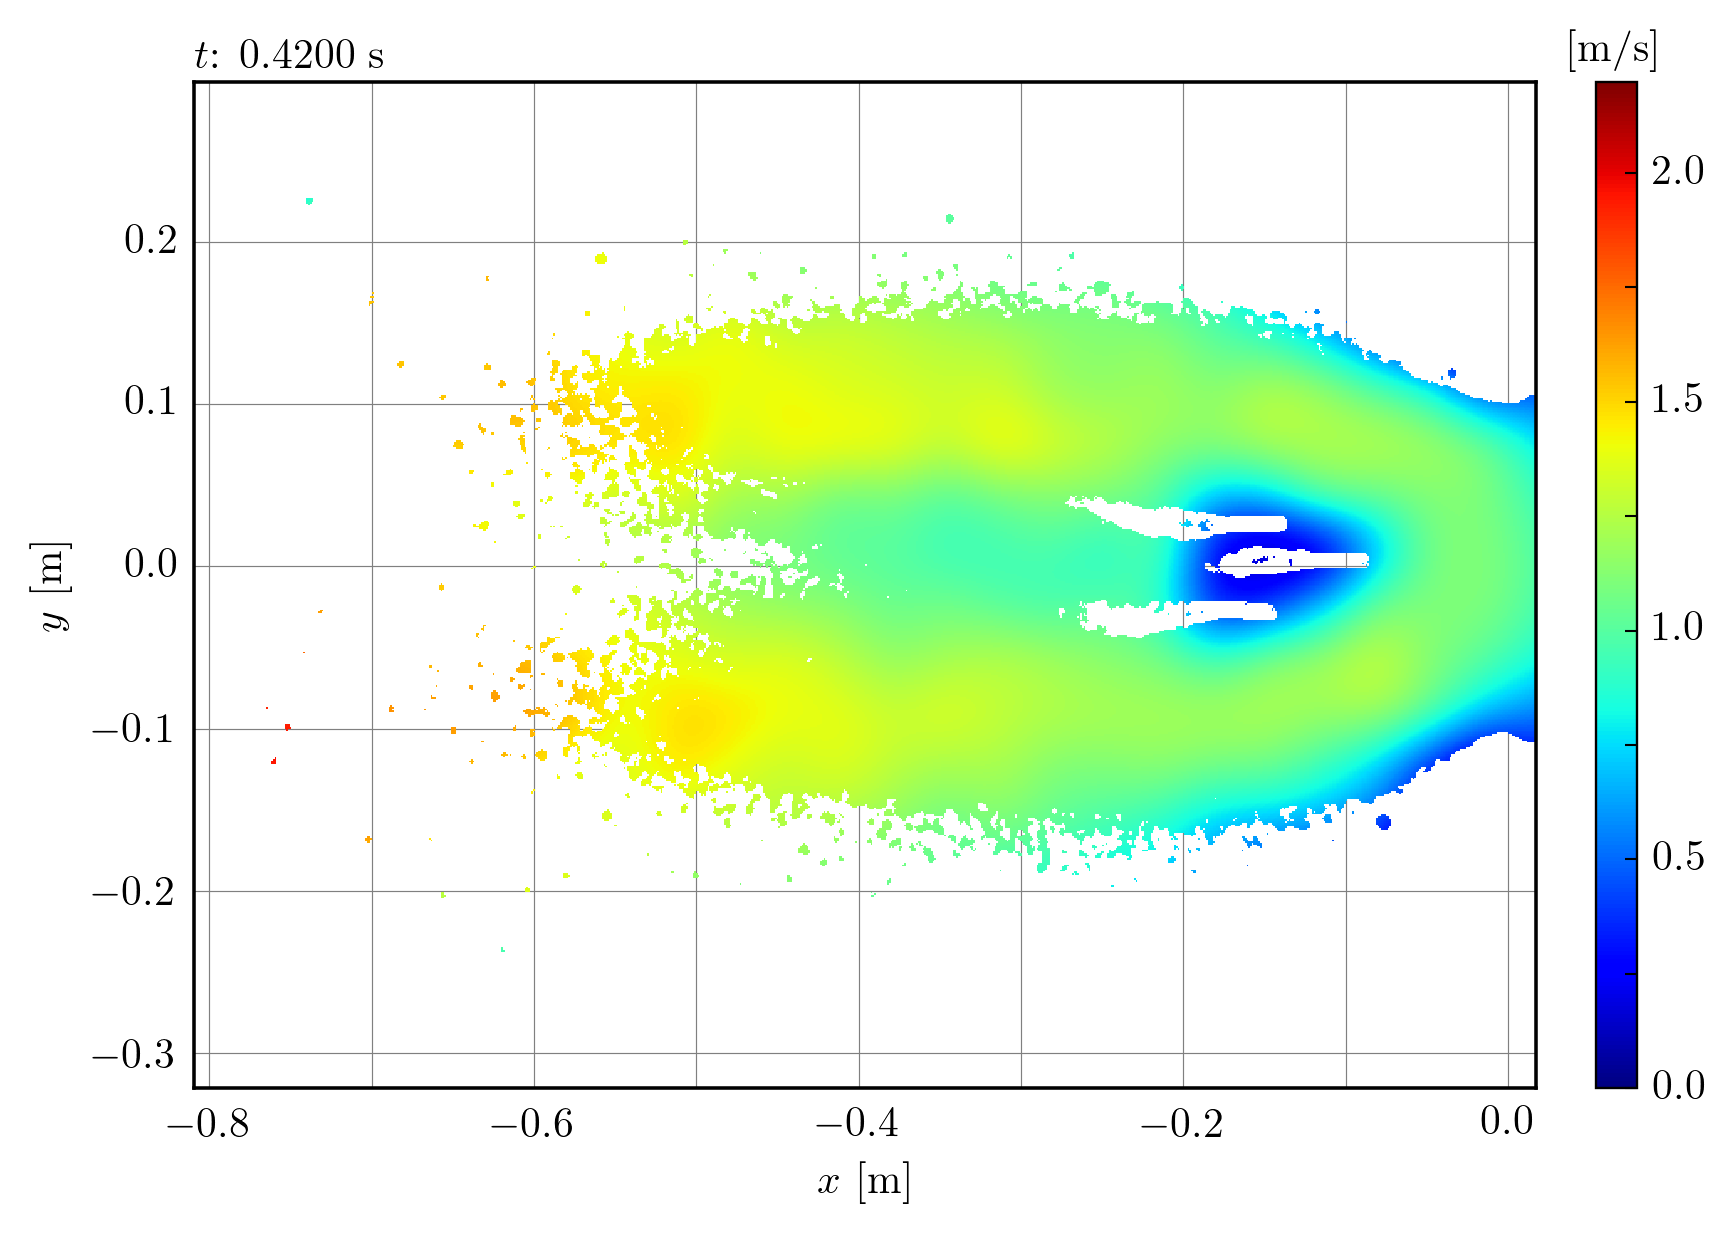

[-0.80922446  0.01756937 -0.3214161   0.29867927]
2.2


/opt/python3.4Env/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


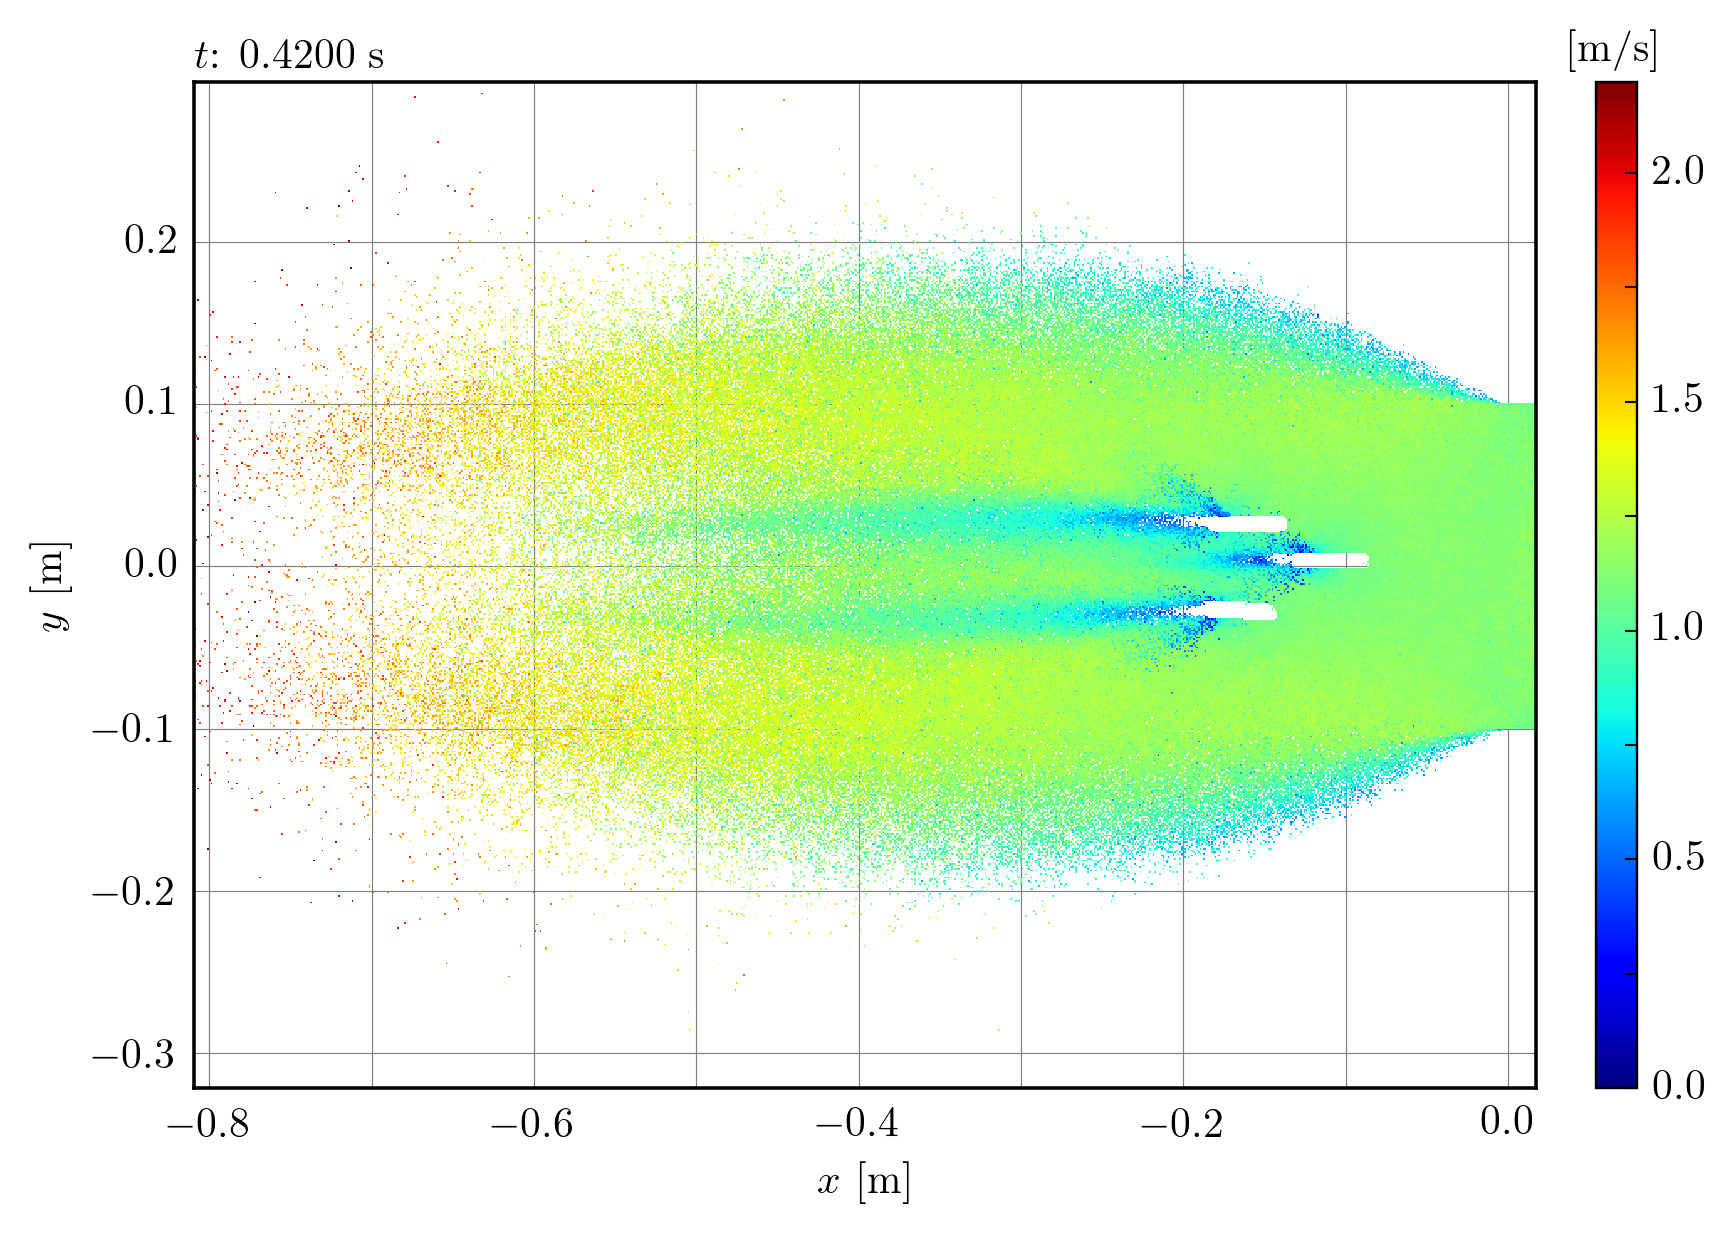

/opt/python3.4Env/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


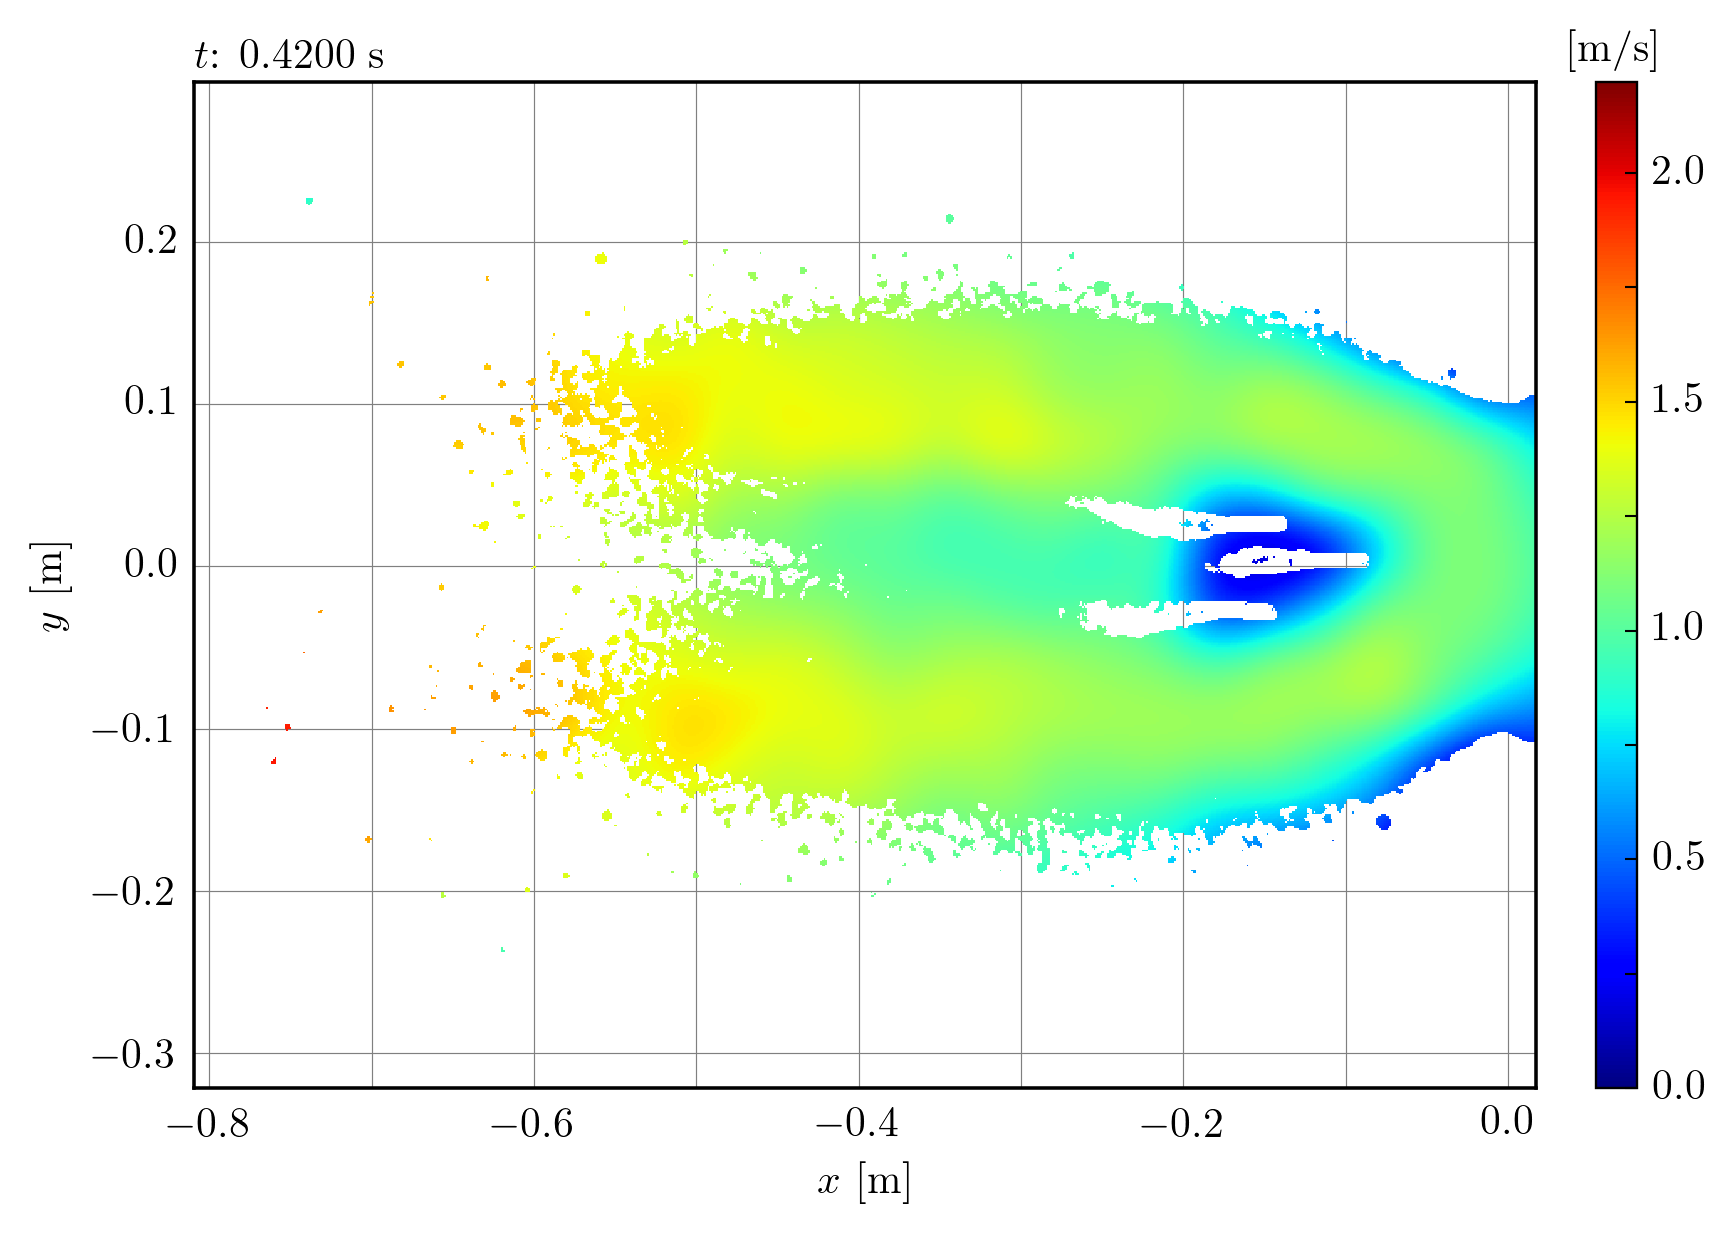

In [21]:
# Plot CIV grid and SIM grid
plt.close("all")
for studyNr in [9,14]:
    study = studyDataVelMag[studyNr]
    bounds=study["gridFile"].getPlotBounds((0,1))
    print(bounds)
    i = 10
    print(velocityMaxNorm)
    for name, data in [ ("VelGrid",study["slice"][:,:,i].T), ("CIVVelGrid", study["civVelMag"][:,:,i].T ) ]:

        fig = plt.figure(figsize=figureSize)
        ax = fig.add_subplot(111, aspect='equal')

        plotGridData2d(
                    ax,
                    data,
                    bounds, 
                    timeAnnotation="$t$: %.04f s" % (study["time"][i]-study["entryTime"]))

        fig.savefig("%s-P-%i-i-%i.pdf" %(name,studyNr,i),dpi=400)
        plt.show()

In [ ]:
# test stuff to delete
def insideImageMask(mask,x,y):
    return mask[x,y]
        
gridSize = [600,800]


bounds = [0,0.5,0,0.5]
dim = np.array([gridSize[1],gridSize[0]],dtype=int) # acciv grid is (y,x) indexed with left-bottom corner as
mask = np.random.randint(0,2,size=dim).astype(bool)
plt.imshow(mask)
print(dim)
minPoint = np.array([bounds[0],bounds[2]],dtype=float)
print(minPoint)
maxPoint = np.array([bounds[0+1],bounds[2+1]],dtype=float)
dxInv = 1.0/((maxPoint - minPoint) / dim)
points = np.random.random(size=(20000,2))
#print("points\n",points)
indices = ((points - minPoint) * dxInv).astype(int)
#print("indices",indices)
validIndices = np.logical_not(
                 ((indices[:,0] < 0) | (indices[:,0] >= dim[0])) |
                 ((indices[:,1] < 0) | (indices[:,1] >= dim[1]))
                )

allPoints = points[validIndices]
allIndices = indices[validIndices]
print("all indices",allIndices)

indexMask = np.logical_not(mask[allIndices[:,0],allIndices[:,1]])

print(indexMask)

Video Frames Rendering
===

In [15]:
# load all grid files
fileGlobbingExpression = "./gridVelocities/all/GridVelocity-P-*/*.h5"
filesPerStudyNr = getAllGridFiles(fileGlobbingExpression)
print("Files: ", filesPerStudyNr)
studyNrs = sorted(list(filesPerStudyNr.keys()))

# Load Masks and Velocities from Simulation ===================
studyData = {}
for studyNr,file in filesPerStudyNr.items():
    print("Open file: file %s", file[gridFileName])
    studyData[studyNr] = { "gridFile" : GridFile(file[gridFileName]) }
    
# output file
outputFolder = "plots-p%d/comparisonPlotsVelMag" % civPassNr
os.makedirs(outputFolder,exist_ok=True)
outputFileTemplate = os.path.join(outputFolder, "%s-P-%i-i-%i.jpg" )

Files:  {0: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-0/GridFileVelocityField.h5'}, 1: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-1/GridFileVelocityField.h5'}, 2: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-2/GridFileVelocityField.h5'}, 3: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-3/GridFileVelocityField.h5'}, 4: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-4/GridFileVelocityField.h5'}, 5: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-5/GridFileVelocityField.h5'}, 6: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-6/GridFileVelocityField.h5'}, 7: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-7/GridFileVelocityField.h5'}, 8: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-8/GridFileVelocityField.h5'}, 9: {'GridFileVelocityField.h5': './gridVelocities/all/GridVelocity-P-9/GridFileVelocityField.h5'}, 1

In [ ]:
plt.close("all")
import gc
from matplotlib import figure
mpl.use('Agg')
%matplotlib inline
mpl.rcParams.update ( {'font.family' : 'sans-serif', 'font.size' : 8, 'font.weight' : 'bold',
                       'text.latex.preamble' : rcParamsOrig['text.latex.preamble'],
                       'verbose.level' : 'debug'
                      })

skipAlreadyPlotted = True

def changeAxis(ax,size):
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_visible(True)
        label.set_fontsize(size) # Size here overrides font_prop
        
makeMag = lambda g : np.sqrt(g[:,:,0]**2 + g[:,:,1]**2)
makeMag2 = lambda x,y : np.sqrt(x[...]**2 + y[...]**2)

# iterate over all grid velocities
for studyNr, data in studyData.items():
    
    # iterate over all state
    g = data["gridFile"];
    bounds=data["gridFile"].getPlotBounds((0,1))
    
    for state in g.getStates():
        stateIdx = state["globalStateIdx"]
        time = state["time"]
        filePath = outputFileTemplate %("VelocityMag",studyNr,stateIdx);
        if skipAlreadyPlotted:
            if os.path.exists(filePath):
#                 print("skip: ", filePath)
                continue;
        
        print("Save to: %s" % filePath)

        # load mask
        mask = g.readGrid(state["h5Group"],gridName=maskName)
        # load velocity
        velMag = makeMag(g.readGrid(state["h5Group"],gridName=gridName))
        velMag = np.ma.masked_array(velMag , mask=makeSimMask( mask )) 
        print("Vel. Shape: ", velMag.shape)                   
        # load civ file
        entryTime = studyEntryData["studies"][str(studyNr)]["entryTime"]
        civMask   = np.zeros(expSettings["resolution"] ,dtype=np.uint8)
        civVelMag = np.zeros(expSettings["resolution"] ,dtype=float)
        print("Load CIV mask/data (shape: %s) for studyNr: %i" % (str(civMask.shape),studyNr))
        print("match time: ", time , " at stateIdx: ", stateIdx)
        civIdx = getCIVFrameIdx(time-entryTime,expDeltaT,expStartIdx)
        print("civ idx: ", civIdx)
        
        # load the image file and get mask 
        print("Load CIV %s for simTime: %f at civIdx: %i" % (maskName,time,civIdx))
        f = h5py.File(civImageFiles[civIdx])
        if computeNewMask:
            # image is (y,x, origin at lower left corner)
            image = f[civImageName][...].transpose() # make it (x,y)
            civMask = treeMask * makeCivMask(image,expBackground)
        else:
            image = f[civImageName][...].transpose() # make it (x,y)
            civMask = civImageDataPostLoadOperator(f[civMaskName][...].astype(np.uint8))
        f.close()
        
        # load the data file (velocities)
        print("Load CIV velocity for simTime: %f at frameIdx: %i" % (time,civIdx))
        f = h5py.File(civGridFiles[civIdx])
        civVelMag = makeMag2(f[civVelXName], f[civVelYName]).T
        f.close()
        # mask civ data
        civVelMag = np.ma.masked_array(civVelMag, mask= np.logical_not(civMask) )
        #print("CIV Vel. Shape: ", civVelMag.shape)
        
        # plot grid
        #print(bounds)
        fig = figure.Figure(figsize=[6,3.5])
        ax1 = fig.add_subplot(1,2,1, aspect='equal')
        #im1, timeText1 =  
        plotGridData2d(ax1,velMag,
                           bounds = [bounds[2],bounds[3],bounds[0],bounds[1]],
                           #timeAnnotation="$t$: %.04f s" % (time-entryTime),
                           cbarFormat = False,
                           noLabels = True   
                          )
        ax1.set_title(r"\textsf{\textbf{Simulation Grid}}", fontdict={"fontsize":pS.defaultFontSize})
        changeAxis(ax1,8)
        
        ax2 = fig.add_subplot(1,2,2, aspect='equal')
        #im2, timeText2 = 
        plotGridData2d(ax2,civVelMag,
                           bounds = [bounds[2],bounds[3],bounds[0],bounds[1]], 
                           #timeAnnotation="$t$: %.04f s" % (time-entryTime),
#                            cbarFormat = False,
                           cbarFormat = ticker.FuncFormatter(lambda x,pos: r"$\mathbf{%0.1f}$"%x),
                           noLabels = True   
                          )
        ax2.set_title(r"\textsf{\textbf{Experiment CIV}}", fontdict={"fontsize":pS.defaultFontSize})
        changeAxis(ax2,8)
        
        ax2.yaxis.set_major_formatter(plt.NullFormatter())
        
        fig.text(0.43,0.95,r"$t$: $\mathtt{%.04f}$ \si{\second}" % (time-entryTime), size=10)
        
        fig.tight_layout(pad=0.1)
        fig.subplots_adjust(top=0.93, bottom=0.05)
        fig.savefig(filePath, dpi=300)
        
        # clean up
        fig.clear()
        plt.close(fig)
        plt.close("all")
        del fig, velMag, civVelMag, mask, civMask, image, f
        gc.collect()

        #raise NameError("asd")
        

/opt/python3.4Env/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/opt/python3.4Env/lib/python3.4/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


Save to: plots-p2/comparisonPlotsVelMag/VelocityMag-P-0-i-107.jpg
Vel. Shape:  (800, 600)
Load CIV mask/data (shape: (800, 600)) for studyNr: 0
match time:  0.21400000000000408  at stateIdx:  107
civ idx:  340
Load CIV mask for simTime: 0.214000 at civIdx: 340
Load CIV velocity for simTime: 0.214000 at frameIdx: 340
Save to: plots-p2/comparisonPlotsVelMag/VelocityMag-P-0-i-108.jpg
Vel. Shape:  (800, 600)
Load CIV mask/data (shape: (800, 600)) for studyNr: 0
match time:  0.21600000000000413  at stateIdx:  108
civ idx:  342
Load CIV mask for simTime: 0.216000 at civIdx: 342
Load CIV velocity for simTime: 0.216000 at frameIdx: 342
Save to: plots-p2/comparisonPlotsVelMag/VelocityMag-P-0-i-109.jpg
Vel. Shape:  (800, 600)
Load CIV mask/data (shape: (800, 600)) for studyNr: 0
match time:  0.2180000000000042  at stateIdx:  109
civ idx:  344
Load CIV mask for simTime: 0.218000 at civIdx: 344
Load CIV velocity for simTime: 0.218000 at frameIdx: 344
Save to: plots-p2/comparisonPlotsVelMag/Velocit